# Simple PGM with linear regression
------

First the following packages, scripts and data has to be loaded

In [1]:
# Standard libraries
import os
import pickle

# Data manipulation
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import pyplot as plt  # (duplicate removed)

# Machine Learning
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

# PyTorch
import torch

# Pyro
import pyro
import pyro.poutine as poutine
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS, HMC, SVI, Trace_ELBO, Predictive
from pyro.optim import Adam, ClippedAdam
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal, AutoNormal
from pyro.infer.autoguide import AutoNormal  # (already imported above from contrib)

# Custom modules
from helper_functions.utils import split_patient_level
from helper_functions.Preprocess_df import standardize_input, standardize_tensor
from helper_functions.Preprocess_df import reverse_standardize_tensor


# RUN THE SCRIPT helper_functions/Clean_data.py ONE TIME
# load data CaseRigshospitalet_summed.parquet
df = pd.read_parquet('data/CaseRigshospitalet_summed.parquet')

/Users/signeolsen/opt/anaconda3/envs/MachineLearning/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


These notebooks will take you thourgh some models, which seek to predict the visit duration $v$ in hours. 

In this notebook we would like to take you through the following contet.

### Content
* Visualization of the data
* Preprocessing the dataset
* Heteroscedatic regression model using diagnostic
* Heteroscedatic regression model using diagnostic and demographic data of a patient
* Simple regression model using diagnostic and demographic data of a patient

## Visualization of the data

First we will have a look at the data that we are working with, run the following code and have a look at some of the attributes (it is in danish).


In [2]:
print(df.head())

  Patient ID Aktionsdiagnosekode  totalDiagnoseKontaktVarighed  \
0       Z100               DM059                          1.65   
1   Z1000004              DG930A                          0.32   
2   Z1000010              DM511D                          6.98   
3   Z1000010               DM549                          1.43   
4   Z1000018               DQ253                          3.85   

   antalKontakter  antalDiagnoser      alder  gender civilStand  \
0               2               1       51.0  Kvinde       Gift   
1               1               1       32.0    Mand       Gift   
2               5               2       45.2    Mand       Gift   
3               1               2       45.0    Mand       Gift   
4               3               1  44.666667    Mand      Ugift   

   distanceToHospitalKM patientKommune  \
0              0.974812      København   
1             18.368636         Furesø   
2              2.963563      København   
3              2.963563      Køb

Since we are working with predicting time we take log and standadize, look at the transformation below.

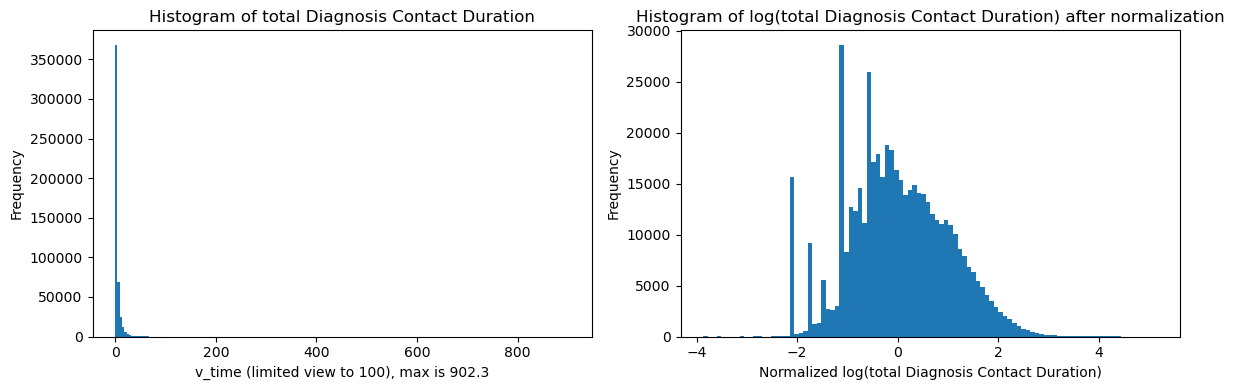

In [3]:
v_time = df["totalDiagnoseKontaktVarighed"]
fig, ax = plt.subplots(1,2, figsize=(12, 4))
ax[0].hist(v_time, bins=200)
ax[0].set_title("Histogram of total Diagnosis Contact Duration")
ax[0].set_xlabel(f"v_time (limited view to 100), max is {np.max(v_time):.1f}")
ax[0].set_ylabel("Frequency")

v_time_log = np.log(v_time)

#standize
v_time_log = (v_time_log-np.mean(v_time_log))/np.std(v_time_log)
ax[1].hist(v_time_log, bins=100)
ax[1].set_title("Histogram of log(total Diagnosis Contact Duration) after normalization")
ax[1].set_xlabel("Normalized log(total Diagnosis Contact Duration)")
ax[1].set_ylabel("Frequency")
plt.tight_layout()
plt.show()

## Preprocessing the dataset

Lets split the data into a trainingset and a testset, thereafter we standadize it.

In [4]:
# Split the data into training and test sets
(x_emb_train, d_demo_train, v_time_train, a_count_train), (x_emb_test, d_demo_test, v_time_test, a_count_test) = split_patient_level(df, total_samples=len(df))

# Standardize the embeddings and demographic data
x_emb_train_pca, x_emb_test_pca, d_demo_train, d_demo_test = standardize_input(x_emb_train, x_emb_test, d_demo_train, d_demo_test)
# Standardize the log v_time_train
v_time_train, mean_v_time_train, std_v_time_train = standardize_tensor(torch.log(v_time_train))

Demographic columns: ['alder', 'distanceToHospitalKM', 'gender_Kvinde', 'gender_Mand', 'gender_Ukendt', 'civilStand_Fraskilt', 'civilStand_Gift', 'civilStand_Ugift']


## Heteroscedastic regression model using diagnostic

The dataset have an attribute called 'Action diagnostic code', which we have made an Bert embedding on.

The Heteroscedatic regression model take as input a BERT embedding of the observed variable diagnosis description, $\bm{x}=BERT(diagnosis)$. 

The Generative Process
1) Draw $\beta_k \sim \mathcal{N}(0,1)$, for $k \in \{1,2,\dots, K\}$

2) Draw $\eta_k \sim \mathcal{N}(0,1)$, for $k \in \{1,2,\dots, K\}$

3) For each patient, $p$, in $P$

    a) $scale = softplus(\eta^T [1,\mathbb{x}_p])$

    b) Draw $v_p \sim \mathcal{N}(\beta^T[1,\mathbb{x}_p],scale)$,


Define test and train for the model

In [5]:
# add ones as the intercept term
ones_train = torch.ones((x_emb_train_pca.shape[0], 1), dtype=torch.float32)
X_train = torch.cat((ones_train, x_emb_train_pca), dim=1)

ones_test = torch.ones((x_emb_test_pca.shape[0], 1), dtype=torch.float32)
X_test = torch.cat((ones_test, x_emb_test_pca), dim=1)

v_train = v_time_train
v_test = v_time_test

### Model and ELBO optimization

In [6]:
# ==== Data ====
X = X_train
y = v_train

# ==== Model ====
def heteroscedastic_regression(data, targets=None):
    P, D = data.shape

    # Prior on beta and eta
    beta = pyro.sample("beta", dist.Normal(0., 1).expand([D]).to_event(1))
    eta = pyro.sample("eta", dist.Normal(0., 1).expand([D]).to_event(1))

    with pyro.plate("data", P):
        loc = data @ beta
        scale = torch.nn.functional.softplus(data @ eta)
        pyro.sample("v", dist.Normal(loc, scale), obs=targets)

# ==== Guide ====
guide = AutoNormal(heteroscedastic_regression)

# ==== Optimizer ====
pyro.clear_param_store()
adam_params = {"lr": 0.005}
optimizer = ClippedAdam(adam_params)

# ==== Inference ====
elbo = Trace_ELBO(num_particles=3)
svi = SVI(heteroscedastic_regression, guide, optimizer, loss=elbo)

n_steps = 1500
loss_curve = np.zeros(n_steps)
for step in range(n_steps):
    loss = svi.step(X, y)
    loss_curve[step] = loss
    if step % 500 == 0:
        print(f"[{step}] ELBO: {loss:.2f}")

# ==== Posterior Mean Estimates ====
posterior = guide(X)
beta_mean_d = posterior["beta"]
eta_mean_d = posterior["eta"]

print("\nPosterior mean of beta (first 5 dims):", beta_mean_d[:5])
print("Posterior mean of eta (first 5 dims):", eta_mean_d[:5])


[0] ELBO: 65461526.66
[500] ELBO: 511585.67
[1000] ELBO: 485654.21

Posterior mean of beta (first 5 dims): tensor([ 0.0018, -0.0217,  0.0278,  0.0145,  0.0289], grad_fn=<SliceBackward0>)
Posterior mean of eta (first 5 dims): tensor([ 0.2738, -0.0170,  0.0046, -0.0172,  0.0247], grad_fn=<SliceBackward0>)


We will have a closer look at the Elbo, run the following code to see the loss curve

findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmr10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmtt10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmmi10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmb10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmss10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmex10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['DejaVu Sans Display'] not found. Falling back to DejaVu Sans.


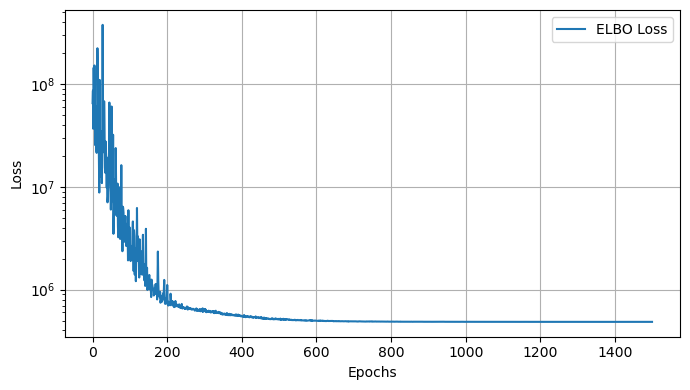

In [7]:
# plot loss curve
plt.figure(figsize=(7, 4))
plt.plot(loss_curve, label='ELBO Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('log')
plt.grid(True)
plt.legend()
plt.tight_layout()


We see a decreasing ELBO curve, however, the value is still high.

We now use the learned parameters to make predictions on the test set.

First define the predictive function

In [8]:
from pyro.infer import SVI, Predictive
predictive = Predictive(
    heteroscedastic_regression,
    guide=guide,
    num_samples=200,
    return_sites=["v"]
)

Sample som points for the predictive sampling

In [9]:
# Predictive sampling
samples = predictive(X_test)

# Compute mean of predictions and reverse standardization and reverse log transformation
pred_v_log = samples["v"].mean(0)
pred_v_log = reverse_standardize_tensor(pred_v_log, mean_v_time_train, std_v_time_train)
pred_v = torch.exp(pred_v_log)
pred_v = pred_v.cpu().numpy()

# Get the “true” values
true_v   = v_time_test.cpu().numpy()

# samples["obs_logv"] has shape: (num_samples, num_data_points)
pred_v_log_samples = samples["v"]  # shape: (num_samples, N)

# Reverse standardize each sample separately
pred_v_log_samples = reverse_standardize_tensor(pred_v_log_samples, mean_v_time_train, std_v_time_train)

# Exponentiate to get pred_v for each sample
pred_v_samples = torch.exp(pred_v_log_samples)

# Convert to NumPy for further analysis
pred_v_samples = pred_v_samples.cpu().numpy() 

true_v_expanded = np.expand_dims(true_v, axis=0)  # Add a new axis at the beginning
true_v_copied = np.repeat(true_v_expanded, pred_v_samples.shape[0], axis=0)
print(true_v_copied.shape)
print(pred_v_samples.shape)

# Flatten the predictions and truths
true_v_flat = true_v_copied.flatten()
pred_v_flat = pred_v_samples.flatten()

# Compute RMSE
all_rmse = np.sqrt(mean_squared_error(true_v_flat, pred_v_flat))
print(f"Overall RMSE for all groups: {all_rmse:.3f}")


(200, 97805)
(200, 97805)
Overall RMSE for all groups: 12.355


Clamp the few (aproximatly 10) values that are around 1000, will not effect RMSE

In [10]:
# Clamp all predctions higher then 800
pred_v_flat[pred_v_flat > 800] = 800

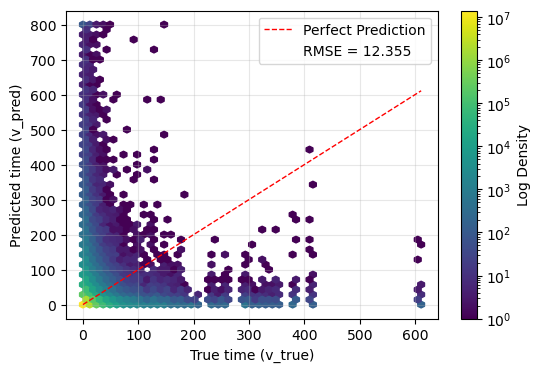

In [11]:
plt.figure(figsize=(6, 4))
hb = plt.hexbin(true_v_flat, pred_v_flat, gridsize=50, cmap='viridis', bins='log')  # bins='log' for log-scaling
plt.colorbar(label="Log Density")
plt.plot(
    [true_v_flat.min(), true_v_flat.max()],
    [true_v_flat.min(), true_v_flat.max()],
    'r--', linewidth=1, label="Perfect Prediction"
)
plt.plot([], [], ' ', label=f"RMSE = {all_rmse:.3f}")

plt.xlabel("True time (v_true)")
plt.ylabel("Predicted time (v_pred)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

The Predictions based on $20\%$ of the test dataset are poorly aligned with the true values, leading to an RMSE of 12.4.

## Heteroscedatic regression model using diagnostic and demographic data of a patient

Next, we extend the heteroscedastic regression model to also incorporate demographic data. The input now consists of both the BERT embedding and the patient’s demographic features, denoted by $d$. The input is then $[1,\bm{x},\bm{d}]$. The generative process remains unchanged; only the input representation is modified.

In [12]:
X_train_full = torch.cat((X_train, d_demo_train), dim=1)
X_test_full = torch.cat((X_test, d_demo_test), dim=1)

### Model and ELBO optimization

In [13]:
# ==== Data ====
X = X_train_full
y = v_time_train

# ==== Model ====
def heteroscedastic_regression(data, targets=None):
    P, D = data.shape

    # Prior on beta and eta
    beta = pyro.sample("beta", dist.Normal(0., 1).expand([D]).to_event(1))
    eta = pyro.sample("eta", dist.Normal(0., 1).expand([D]).to_event(1))

    with pyro.plate("data", P):
        loc = data @ beta
        scale = torch.nn.functional.softplus(data @ eta) + 1e-8

        pyro.sample("v", dist.Normal(loc, scale), obs=targets)

# ==== Guide ====
guide = AutoNormal(heteroscedastic_regression)

# ==== Optimizer ====
pyro.clear_param_store()
adam_params = {"lr": 0.005}
optimizer = ClippedAdam(adam_params)

# ==== Inference ====
elbo = Trace_ELBO(num_particles=3)
svi = SVI(heteroscedastic_regression, guide, optimizer, loss=elbo)

n_steps = 5000
loss_curve = np.zeros(n_steps)
for step in range(n_steps):
    loss = svi.step(X, y)
    loss_curve[step] = loss
    if step % 500 == 0:
        print(f"[{step}] ELBO: {loss:.2f}")

# ==== Posterior Mean Estimates ====
posterior = guide(X)
beta_mean_PP = posterior["beta"]
eta_mean_PP = posterior["eta"]

print("\nPosterior mean of beta (first 5 dims):", beta_mean_PP[:5])
print("Posterior mean of eta (first 5 dims):", eta_mean_PP[:5])


[0] ELBO: 923588363709956180934656.00
[500] ELBO: 735523.35
[1000] ELBO: 9250748954756306.00
[1500] ELBO: 507045.78
[2000] ELBO: 61341328798191886336.00
[2500] ELBO: 871831551671098496.00
[3000] ELBO: 494004.38
[3500] ELBO: 488432.43
[4000] ELBO: 6808623122169.09
[4500] ELBO: 509775.32

Posterior mean of beta (first 5 dims): tensor([-0.0298, -0.0210,  0.0219,  0.0154,  0.0267], grad_fn=<SliceBackward0>)
Posterior mean of eta (first 5 dims): tensor([ 0.0406, -0.0181,  0.0061, -0.0103,  0.0224], grad_fn=<SliceBackward0>)


We will have a closer look at the mean for every 10th Elbo, run the following code to see the loss curve.

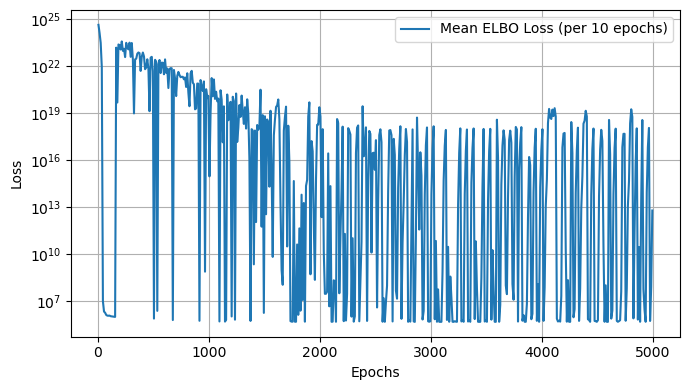

In [14]:
# Compute mean for every 10 points
chunk_size = 10
num_chunks = len(loss_curve) // chunk_size
mean_loss = [np.mean(loss_curve[i * chunk_size:(i + 1) * chunk_size]) for i in range(num_chunks)]

# X-axis values: midpoint of each 10-point chunk
epochs = np.arange(chunk_size // 2, chunk_size * num_chunks, chunk_size)

# Plot mean loss curve
plt.figure(figsize=(7, 4))
plt.plot(epochs, mean_loss, label='Mean ELBO Loss (per 10 epochs)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('log')
plt.grid(True)
plt.legend()
plt.tight_layout()

We now use the learned parameters to make predictions on the test set.

First define the predictive function

In [15]:
from pyro.infer import SVI, Predictive
predictive = Predictive(
    heteroscedastic_regression,
    guide=guide,
    num_samples=200,
    return_sites=["v"]
)

Sample som points for the predictive sampling

In [16]:
# Predictive sampling
samples = predictive(X_test_full)

# Compute mean of predictions and reverse standardization and reverse log transformation
pred_v_log = samples["v"].mean(0)
pred_v_log = reverse_standardize_tensor(pred_v_log, mean_v_time_train, std_v_time_train)
pred_v = torch.exp(pred_v_log)
pred_v = pred_v.cpu().numpy()

# Get the “true” values
true_v   = v_time_test.cpu().numpy()

# samples["obs_logv"] has shape: (num_samples, num_data_points)
pred_v_log_samples = samples["v"]  # shape: (num_samples, N)

# Reverse standardize each sample separately
pred_v_log_samples = reverse_standardize_tensor(pred_v_log_samples, mean_v_time_train, std_v_time_train)

# Exponentiate to get pred_v for each sample
pred_v_samples = torch.exp(pred_v_log_samples)

# Convert to NumPy for further analysis
pred_v_samples = pred_v_samples.cpu().numpy() 

true_v_expanded = np.expand_dims(true_v, axis=0)  # Add a new axis at the beginning
true_v_copied = np.repeat(true_v_expanded, pred_v_samples.shape[0], axis=0)
print(true_v_copied.shape)
print(pred_v_samples.shape)

# Flatten the predictions and truths
true_v_flat = true_v_copied.flatten()
pred_v_flat = pred_v_samples.flatten()


(200, 97805)
(200, 97805)


Clamp the few (aproximatly 10) values that are around 1000, will effect RMSE since it otherwise would be $\inf$

In [17]:
# Clamp all predctions higher then 800
pred_v_flat[pred_v_flat > 800] = 800

# Compute RMSE
all_rmse = np.sqrt(mean_squared_error(true_v_flat, pred_v_flat))
print(f"Overall RMSE for all groups: {all_rmse:.3f}")

Overall RMSE for all groups: 18.758


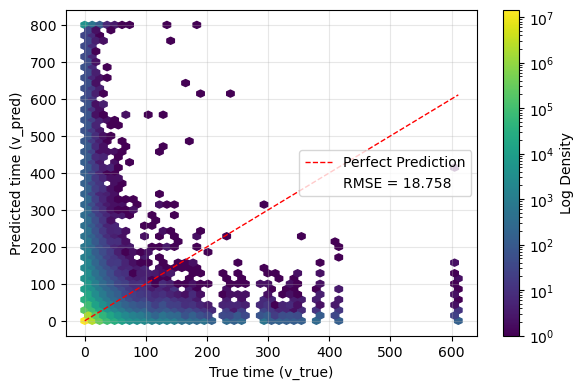

In [18]:
plt.figure(figsize=(6, 4))
hb = plt.hexbin(true_v_flat, pred_v_flat, gridsize=50, cmap='viridis', bins='log')  # bins='log' for log-scaling
plt.colorbar(label="Log Density")

plt.plot(
    [true_v_flat.min(), true_v_flat.max()],
    [true_v_flat.min(), true_v_flat.max()],
    'r--', linewidth=1, label="Perfect Prediction"
)
plt.plot([], [], ' ', label=f"RMSE = {all_rmse:.3f}")

plt.xlabel("True time (v_true)")
plt.ylabel("Predicted time (v_pred)")

# Move legend to the right
plt.legend(loc="center left", bbox_to_anchor=(0.55, 0.5))

plt.grid(alpha=0.3)
plt.tight_layout()  # Helps adjust layout when legend is outside
plt.show()


The model produced unrealistic predictions, exceeding one million hours, while true values never surpassed 1,000. Therefore we have added a thresholder since the model predicts unrealistic high values. 

## Simple regression model using diagnostic and demographic data of a patient

Now we keep the same input data, however we change the model. We discards variance in the encoders and demographic inputs, instead sampling it from a $\text{HalfCauchy}(5.0)$ distribution

The Generative Process
1) Draw $\beta_k \sim \mathcal{N}(0,1)$, for $k \in \{1,2,\dots, K\}$

2) Draw $\eta_k \sim \mathcal{N}(0,1)$, for $k \in \{1,2,\dots, K\}$

3) Draw $\sigma^2 \sim HalfCauchy(5.0)$

4) For each patient, $p$, in $P$

    a) Draw $v_p \sim \text{Normal}(\beta^T[1,\bm{x},\bm{d}], \sigma^2)$


### Model and ELBO optimization

In [19]:
# ==== Data ====
X = X_train_full
y = v_time_train

# ==== Model ====
def log_normal(data, targets=None):
    P, D = data.shape

    # Prior over beta
    beta = pyro.sample("beta", dist.Normal(0., 1.).expand([D]).to_event(1))
    sigma = pyro.sample("sigma", dist.HalfCauchy(5.0))

    with pyro.plate("data", P):
        loc = data @ beta
        pyro.sample("v", dist.Normal(loc, sigma), obs=targets)

# ==== Guide ====
guide = AutoNormal(log_normal)

# ==== Optimizer ====
pyro.clear_param_store()
adam_params = {"lr": 0.005}
optimizer = ClippedAdam(adam_params)

# ==== Inference ====
elbo = Trace_ELBO(num_particles=3)
svi = SVI(log_normal, guide, optimizer, loss=elbo)

n_steps = 1500
loss_curve = np.zeros(n_steps)
for step in range(n_steps):
    loss = svi.step(X, y)
    loss_curve[step] = loss
    if step % 500 == 0:
        print(f"[{step}] ELBO: {loss:.2f}")

# ==== Posterior Mean Estimate ====
posterior = guide(X)
beta_mean_PP_I = posterior["beta"]

print("\nPosterior mean of beta (first 5 dims):", beta_mean_PP_I[:5])

[0] ELBO: 629923181.33
[500] ELBO: 1321778.71
[1000] ELBO: 614884.21

Posterior mean of beta (first 5 dims): tensor([-0.0330, -0.0208,  0.0318,  0.0119,  0.0298], grad_fn=<SliceBackward0>)


We will have a closer look at the Elbo, run the following code to see the loss curve

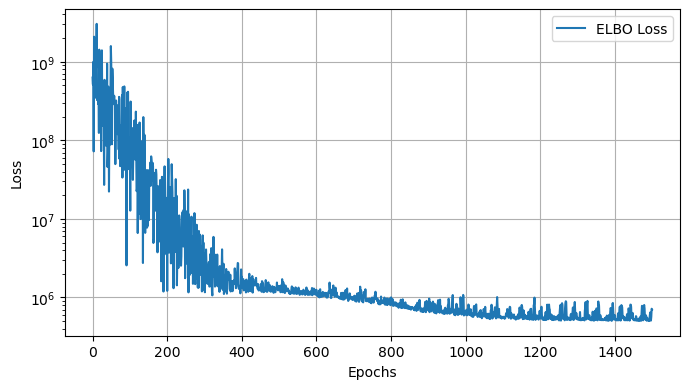

In [20]:
# plot loss curve
plt.figure(figsize=(7, 4))
plt.plot(loss_curve, label='ELBO Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('log')
plt.grid(True)
plt.legend()
plt.tight_layout()

The ELBO decreases overall but remains relatively high.

We now use the learned parameters to make predictions on the test set.

In [21]:
from pyro.infer import SVI, Predictive
predictive = Predictive(
    log_normal,
    guide=guide,
    num_samples=200,
    return_sites=["v"]
)

Sample som points for the predictive sampling

In [25]:
# Predictive sampling
samples = predictive(X_test_full)

# Compute mean of predictions and reverse standardization and reverse log transformation
pred_v_log = samples["v"].mean(0)
pred_v_log = reverse_standardize_tensor(pred_v_log, mean_v_time_train, std_v_time_train)
pred_v = torch.exp(pred_v_log)
pred_v = pred_v.cpu().numpy()

# Get the “true” values
true_v   = v_time_test.cpu().numpy()

# samples["obs_logv"] has shape: (num_samples, num_data_points)
pred_v_log_samples = samples["v"]  # shape: (num_samples, N)

# Reverse standardize each sample separately
pred_v_log_samples = reverse_standardize_tensor(pred_v_log_samples, mean_v_time_train, std_v_time_train)

# Exponentiate to get pred_v for each sample
pred_v_samples = torch.exp(pred_v_log_samples)

# Convert to NumPy for further analysis
pred_v_samples = pred_v_samples.cpu().numpy() 

true_v_expanded = np.expand_dims(true_v, axis=0)  # Add a new axis at the beginning
true_v_copied = np.repeat(true_v_expanded, pred_v_samples.shape[0], axis=0)
print(true_v_copied.shape)
print(pred_v_samples.shape)

# Flatten the predictions and truths
true_v_flat = true_v_copied.flatten()
pred_v_flat = pred_v_samples.flatten()

# Compute RMSE
all_rmse = np.sqrt(mean_squared_error(true_v_flat, pred_v_flat))
print(f"Overall RMSE for all groups: {all_rmse:.3f}")


(200, 97805)
(200, 97805)
Overall RMSE for all groups: 11.670


Clamp the few (aproximatly 1) values that are around 1000, will not effect RMSE

In [26]:
# Clamp all predctions higher then 800
pred_v_flat[pred_v_flat > 800] = 800

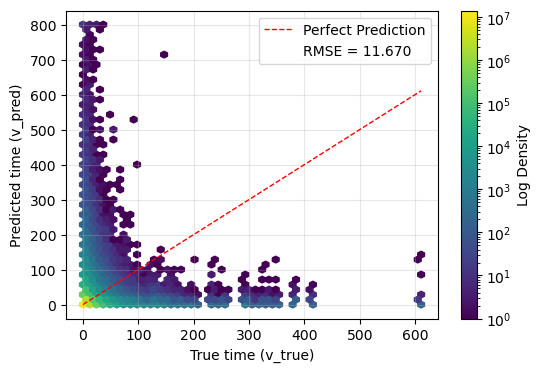

In [27]:
plt.figure(figsize=(6, 4))
hb = plt.hexbin(true_v_flat, pred_v_flat, gridsize=50, cmap='viridis', bins='log')  # bins='log' for log-scaling
plt.colorbar(label="Log Density")
plt.plot(
    [true_v_flat.min(), true_v_flat.max()],
    [true_v_flat.min(), true_v_flat.max()],
    'r--', linewidth=1, label="Perfect Prediction"
)
plt.plot([], [], ' ', label=f"RMSE = {all_rmse:.3f}")

plt.xlabel("True time (v_true)")
plt.ylabel("Predicted time (v_pred)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

While some predictions align well near zero, most deviate significantly, resulting in a high RMSE of 10.13.